In [101]:
import numpy as np
import itertools
import operator
from datetime import datetime
import sys
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import re
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchmetrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [61]:
import pandas as pd
from pathlib import Path

path = Path("/Users/victorserranogarcia/Documents/ml-projects/data/CTA_-_Ridership_-_Daily_Boarding_Totals_20260205.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [62]:
df.head(12)

,day_type,bus,rail
date,,,
2001-01-01,U,297.192,126.455
2001-01-02,W,780.827,501.952
2001-01-03,W,824.923,536.432
2001-01-04,W,870.021,550.011
2001-01-05,W,890.426,557.917
2001-01-06,A,577.401,255.356
2001-01-07,U,375.831,169.825
2001-01-08,W,985.221,590.706
2001-01-09,W,978.377,599.905


In [63]:
df["rail"] = pd.to_numeric(df["rail"].astype(str).str.replace(".", ""))
df["bus"] = pd.to_numeric(df["bus"].astype(str).str.replace(".", ""))


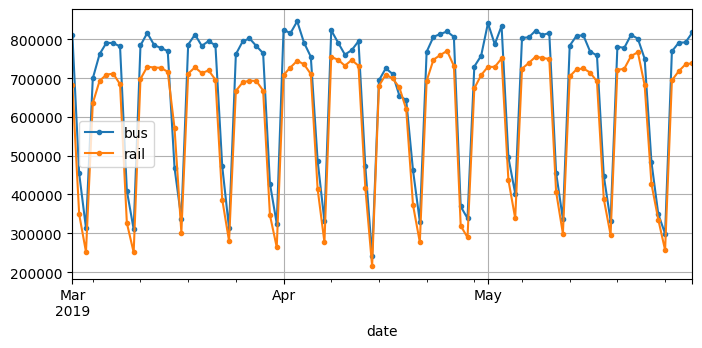

In [64]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [65]:
diff_7 = df[["bus","rail"]].diff(7)["2019-03":"2019-05"]

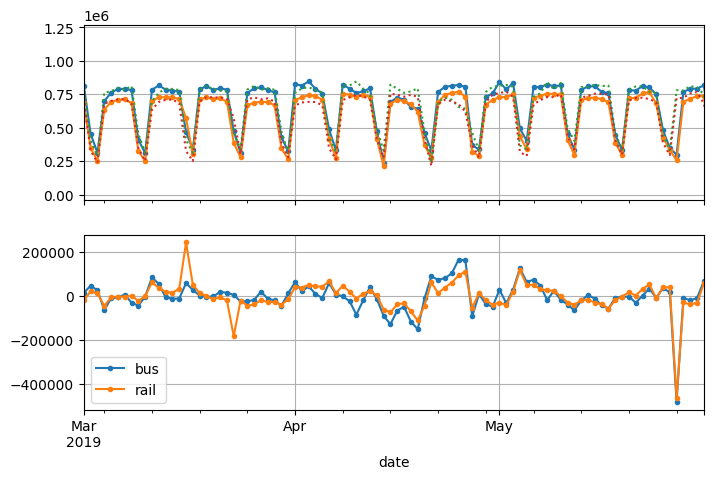

In [66]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))
df.plot(ax=axs[0], legend=False, marker=".")
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff_7.plot(ax=axs[1], grid=True, marker=".")
plt.show()

In [69]:
df.loc["2019-05-25":"2019-05-27"]["day_type"]
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

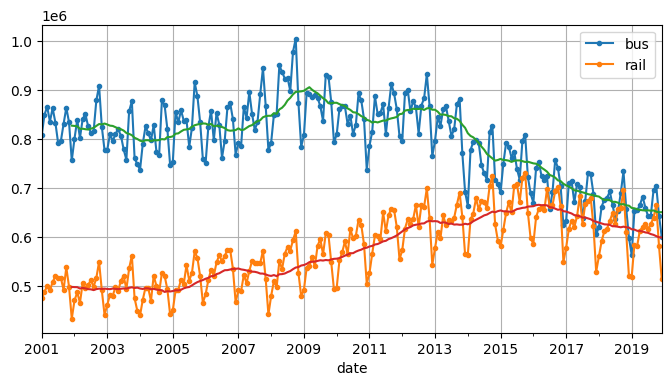

In [70]:
period = slice("2001", "2019")
df_monthly = df.select_dtypes(include="number").resample('ME').mean()
rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

In [74]:
period = slice("2001", "2019")
df_monthly = df.select_dtypes(include="number").resample("ME").mean()
rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()

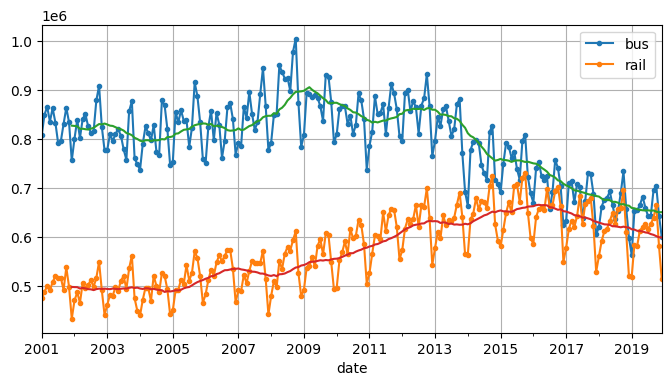

In [79]:
fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

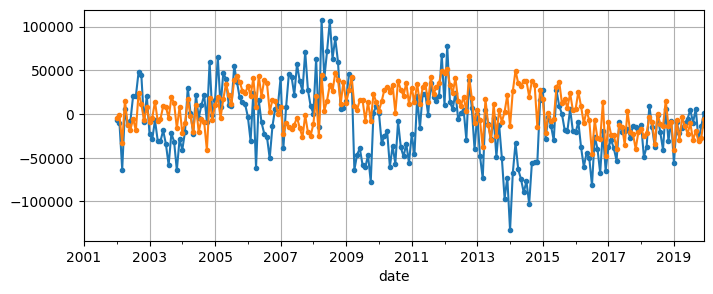

In [ ]:
df_monthly.diff(12)[period].plot(grid=True, legend=False, marker=".", figsize=(8,3))
plt.show()

In [86]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_length):
        self.series = series
        self.window_length = window_length

    def __len__(self):
        return len(self.series) - self.window_length

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")

        end = idx + self.window_length
        window = self.series[idx:end]
        target = self.series[end]
        return window, target

    

In [88]:
series = torch.tensor([[0], [1], [2], [3], [4], [5]])
dataset = TimeSeriesDataset(series, window_length=3)
for window, target in dataset:
    print("Window:", window, "Target:", target)

Window: tensor([[0],
        [1],
        [2]]) Target: tensor([3])
Window: tensor([[1],
        [2],
        [3]]) Target: tensor([4])
Window: tensor([[2],
        [3],
        [4]]) Target: tensor([5])


In [138]:
train = torch.FloatTensor(df["rail"]["2016-01":"2018-12"].values/1e6).unsqueeze(-1)
validation = torch.FloatTensor(df["rail"]["2019-01":"2019-05"].values/1e6).unsqueeze(-1)
test = torch.FloatTensor(df["rail"]["2019-06":].values/1e6).unsqueeze(-1)

In [139]:
window = 56
X_train = TimeSeriesDataset(train, window)
train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
X_validation = TimeSeriesDataset(validation, window)
validation_loader = DataLoader(X_validation, batch_size=32)
X_test = TimeSeriesDataset(test, window)
tesr_loader = DataLoader(X_test, batch_size=32)


### FORECASTING WITH A LINEAR MODEL

In [146]:
torch.manual_seed(69)
linear_model = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(window, 128),
    nn.Linear(128, 64),
    nn.Linear(64, 32),
    nn.Linear(32, 16),
    nn.Linear(16, 8),
    nn.Linear(8,1)
    ).to(device)

lossfun = nn.MSELoss()
optimizer = torch.optim.SGD(linear_model.parameters(),lr=0.1, momentum=0.87)
metric = torchmetrics.MeanAbsoluteError().to(device)

In [177]:
def train(model=linear_model, lossfun=lossfun, optimizer=optimizer, metric=metric, epochs=100, train_loader=train_loader):
    for epoch in range(epochs):
        epoch_loss = 0.0
        for X, y in train_loader:
            X,y = X.to(device), y.to(device)
            optimizer.zero_grad()
            #batch_loss = 0.0
            y_pred = model(X)
            loss = lossfun(y_pred, y)
            #batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        #epoch_loss = batch_loss
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")

In [178]:
train()

Epoch: 0, Loss: 0.1842380544403568
Epoch: 1, Loss: 0.18534773006103933
Epoch: 2, Loss: 0.18192412739153951
Epoch: 3, Loss: 0.17636658111587167
Epoch: 4, Loss: 0.1719617893686518
Epoch: 5, Loss: 0.17644176026806235
Epoch: 6, Loss: 0.1772887739352882
Epoch: 7, Loss: 0.17511728790123016
Epoch: 8, Loss: 0.21717935579363257
Epoch: 9, Loss: 0.18731504678726196
Epoch: 10, Loss: 0.18288746057078242
Epoch: 11, Loss: 0.17208433034829795
Epoch: 12, Loss: 0.17381719377590343
Epoch: 13, Loss: 0.17086616693995893
Epoch: 14, Loss: 0.17099825316108763
Epoch: 15, Loss: 0.17762892495375127
Epoch: 16, Loss: 0.17994573060423136
Epoch: 17, Loss: 0.17909271665848792
Epoch: 18, Loss: 0.1743246065452695
Epoch: 19, Loss: 0.17791244422551244
Epoch: 20, Loss: 0.17798364482587203
Epoch: 21, Loss: 0.1686326457420364
Epoch: 22, Loss: 0.16624271671753377
Epoch: 23, Loss: 0.17175943159963936
Epoch: 24, Loss: 0.19088067149277776
Epoch: 25, Loss: 0.18772261054255068
Epoch: 26, Loss: 0.17551611468661577
Epoch: 27, Loss:

#### FORECASTING WITH A SIMPLE RECURRENT NEURAL NETWORK

#### UNIVARIATE INPUT

In [149]:
class SimpleRnnNetwork(nn.Module):
    #Input size is 1 in a univariate input (1 feature)
    #Hidden size is number of recurrent neurons
    #Output size is 1 in order to forecast a single value
    #The memory cell will be used one time per step
    #Tanh activation function is normally more stable than other act. functions in RNNs
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memory_cell = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh()
        )
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        batch_size, window, dimensionality = X.shape
        X = X.transpose(0, 1)
        hidden_state = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X:
            XH = torch.cat((X_t, hidden_state), dim=1)
            hidden_state = self.memory_cell(XH)
        return self.output(hidden_state)

torch.manual_seed(69)
simple_rnn_model = SimpleRnnNetwork(input_size=1, hidden_size=32, output_size=1)

In [150]:
class SimpleRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=3)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

simple_rnn = SimpleRnnModel(input_size=1, hidden_size=32, output_size=1)

In [155]:
optimizer_2 = torch.optim.Adam(simple_rnn.parameters(), lr=0.001)
train(model=simple_rnn, optimizer=optimizer_2,epochs=10)

Epoch: 0, Loss: 0.17753083840943873
Epoch: 1, Loss: 0.16833336459239945
Epoch: 2, Loss: 0.16281303414143622
Epoch: 3, Loss: 0.1596523248590529
Epoch: 4, Loss: 0.15595514909364283
Epoch: 5, Loss: 0.15900883229915053
Epoch: 6, Loss: 0.16297825856599957
Epoch: 7, Loss: 0.15716297621838748
Epoch: 8, Loss: 0.15711789508350194
Epoch: 9, Loss: 0.15397024620324373


### MULTIVARIATE INPUT

### MULTIVARIATE DATAFRAME

### WE CAN ADD CONTEXTUAL FEATURES LIKE TYPE OF DAY BY DOING ONE HOT ENCODING

In [159]:
df_multivariate = df[["rail", "bus"]] / 1e6  
df_multivariate["next_day_type"] = df["day_type"].shift(-1)  
df_multivariate = pd.get_dummies(df_multivariate, dtype=float)  # one-hot encoding day type

In [168]:
X_train_mv = torch.FloatTensor(df_multivariate["2016-01":"2018-12"].values / 1e6)
X_validation_mv = torch.FloatTensor(df_multivariate["2019-01":"2019-05"].values / 1e6)
X_test_mv = torch.FloatTensor(df_multivariate["2019-06":].values / 1e6)

### WE CHANGE THE TIMESERIES DATA SET CLASS IN ORDER TO CHANGE THE GET ITEM FUNCTION

In [169]:
class MultivariateTimeSeriesDataset(TimeSeriesDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[:1]

In [171]:
multivariate_train = MultivariateTimeSeriesDataset(X_train_mv, window)
multivariate_train_loader = DataLoader(multivariate_train, batch_size=32, shuffle=True)
multivariate_validation = MultivariateTimeSeriesDataset(X_validation_mv, window)
multivariate_validation_loader = DataLoader(multivariate_validation, batch_size=32)
multivariate_test = MultivariateTimeSeriesDataset(X_test_mv, window)
multivariate_test_loader = DataLoader(multivariate_test, batch_size=32)

### CREATE THE SAME MODEL BUT CHANGING THE INPUT SIZE

In [180]:
multivariate_rnn_model = SimpleRnnModel(input_size=5, hidden_size=32, output_size=1).to(device)
optimizer_3 = torch.optim.Adam(multivariate_rnn_model.parameters(), lr=0.001)

train(model=multivariate_rnn_model, optimizer = optimizer_3, epochs=10, train_loader=multivariate_train_loader)

Epoch: 0, Loss: 0.034482600168757926
Epoch: 1, Loss: 0.0007804799575836796
Epoch: 2, Loss: 3.037400213065991e-05
Epoch: 3, Loss: 8.504657132910043e-07
Epoch: 4, Loss: 2.8387426334076926e-08
Epoch: 5, Loss: 1.1228727708387752e-09
Epoch: 6, Loss: 3.0837463520092456e-11
Epoch: 7, Loss: 2.1634335067090586e-12
Epoch: 8, Loss: 1.0846886031783218e-12
Epoch: 9, Loss: 9.471707865591058e-13
